### Homework 2 - Data from the Web

#### 1. Extract data

Obtain the 200 top-ranking universities in www.topuniversities.com (ranking 2018). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the details page. Store the resulting dataset in a pandas DataFrame.

In [1]:
%matplotlib inline  
import requests
import pandas as pd
import json
import difflib
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

SOURCE="www.topuniversities.com"
LIST=SOURCE + "/university-rankings/world-university-rankings/2018"
DATA_SOURCE="www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt"

LIMIT=200

In [2]:
def clean_numerical_data(data):
    return int(data.replace('\n', '').replace(',', ''))

def clean_percentage_data(data):
    return int(data.replace('%', '')) / 100

def safe_parse(page, selector):
    try:
        return clean_numerical_data(page.select(selector)[0].text)
    except:
        return None

In [3]:
def extract_faculty_members(page):
    total = safe_parse(page, "div.total.faculty div.number")
    international = safe_parse(page, "div.inter.faculty div.number")
    return total, international
    
def extract_student_members(page):
    total = safe_parse(page, "div.total.student div.number")
    international = safe_parse(page, "div.total.inter  div.number")
    return total, international

def extract_data(university):
    url = SOURCE + university['url']
    data = requests.get("http://" + url).text
    page = BeautifulSoup(data, "html5lib")
    
    total_faculty, inter_faculty = extract_faculty_members(page)
    total_student, inter_student = extract_student_members(page)

    university['total_faculty'] = total_faculty
    university['inter_faculty'] = inter_faculty
    university['total_student'] = total_student
    university['inter_student'] = inter_student
    
    return university

In [4]:
def extract_list(url):
    data = requests.get("http://" + url).text
    return json.loads(data)['data']
    
university_list = extract_list(DATA_SOURCE)[:LIMIT]

In [5]:
university_list = [extract_data(university) for university in university_list]

In [6]:
KEEP_TOP = ['title', 'rank_display', 'cc', 'region', 'total_faculty', 'total_student', 'inter_faculty', 'inter_student']
university_list = [ {key: university[key] for key in KEEP_TOP} for university in university_list]

In [7]:
df_top = pd.DataFrame(university_list)
df_top.index = df_top['title']
df_top

,cc,inter_faculty,inter_student,rank_display,region,title,total_faculty,total_student
title,,,,,,,,
Massachusetts Institute of Technology (MIT),US,1679.0,3717.0,1,North America,Massachusetts Institute of Technology (MIT),2982.0,11067.0
Stanford University,US,2042.0,3611.0,2,North America,Stanford University,4285.0,15878.0
Harvard University,US,1311.0,5266.0,3,North America,Harvard University,4350.0,22429.0
California Institute of Technology (Caltech),US,350.0,647.0,4,North America,California Institute of Technology (Caltech),953.0,2255.0
University of Cambridge,GB,2278.0,6699.0,5,Europe,University of Cambridge,5490.0,18770.0
University of Oxford,GB,2964.0,7353.0,6,Europe,University of Oxford,6750.0,19720.0
UCL (University College London),GB,2554.0,14854.0,7,Europe,UCL (University College London),6345.0,31080.0
Imperial College London,GB,2071.0,8746.0,8,Europe,Imperial College London,3930.0,16090.0
University of Chicago,US,635.0,3379.0,9,North America,University of Chicago,2449.0,13557.0


#### 1.b Which are the best universities in term of:

##### (a) ratio between faculty members and students

There are two possible ratio that can be used to answer this question, we can either use the **total** statistics or the **international** ones, we though it is more meaningful to use the **total** to answers this question 

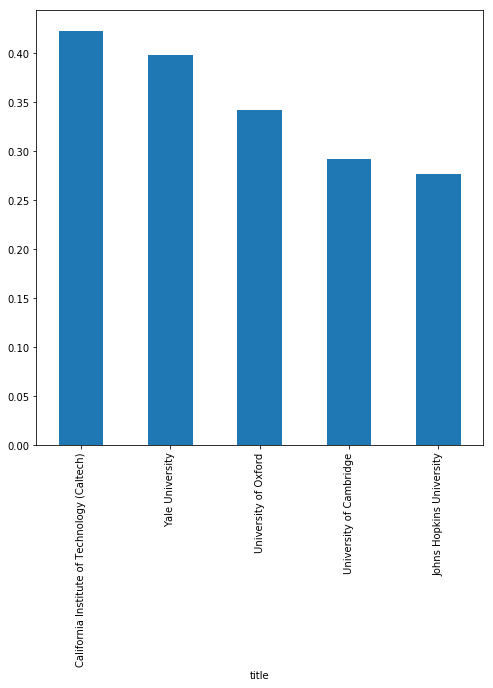

In [8]:
def staff_student_ratio(df):
    df['ratio_faculty_student'] = df['total_faculty'] / df['total_student']
    return df.sort_values('ratio_faculty_student', ascending=False)

staff_student_ratio(df_top)['ratio_faculty_student'].head().plot(kind='bar', figsize=(8,8))

We see that universities with the best ratio between faculty staff and students are located in the US or in GB but that this metric is not closely linked with the rank of the university

##### (b) ratio of international students?

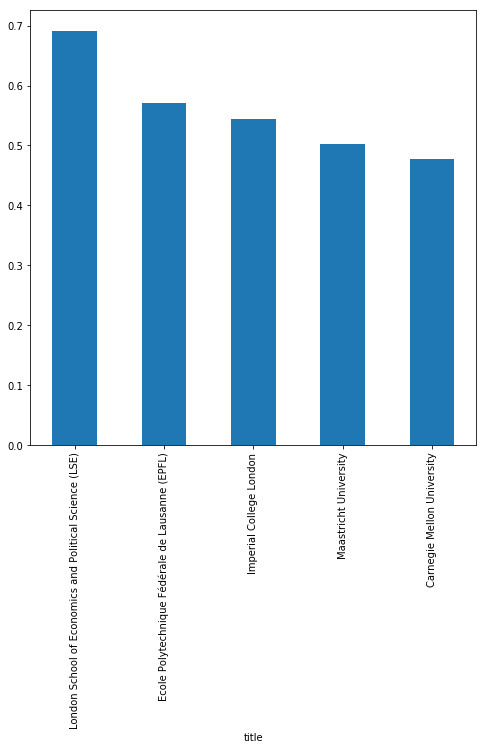

In [9]:
def inter_student_ratio(df):
    df['ratio_inter_student'] = df['inter_student'] / df['total_student']
    return df.sort_values('ratio_inter_student', ascending=False)

inter_student_ratio(df_top)['ratio_inter_student'].head().plot(kind='bar', figsize = (8,8))

Here, we can see that the most international university are mostly located in Europe.

We now need to compute the same ratio, but this time, we'll add some aggregation

##### Country aggregation

In [10]:
df_country = df_top.groupby('cc')['inter_faculty', 'inter_student', 'total_faculty', 'total_student'].sum()

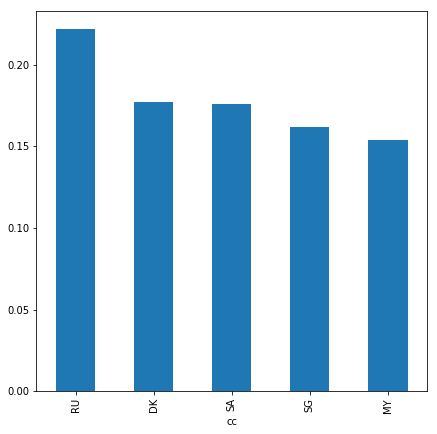

In [11]:
staff_student_ratio(df_country)['ratio_faculty_student'].head().plot(kind='bar', figsize=(7, 7))

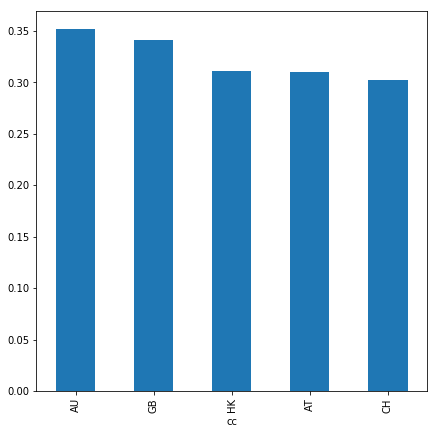

In [12]:
inter_student_ratio(df_country)['ratio_inter_student'].head().plot(kind='bar', figsize=(7, 7))

##### Region aggregation

In [13]:
df_region = df_top.groupby('region')['inter_faculty', 'inter_student', 'total_faculty', 'total_student'].sum()

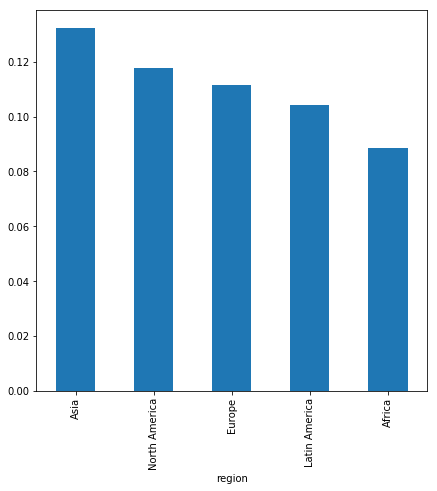

In [14]:
staff_student_ratio(df_region)['ratio_faculty_student'].head().plot(kind='bar',  figsize=(7, 7))

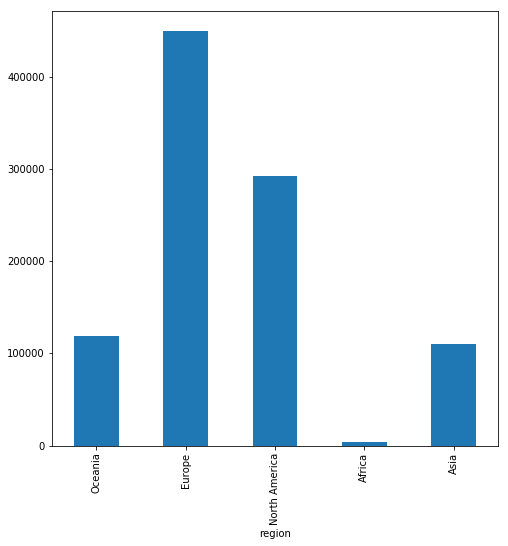

In [15]:
inter_student_ratio(df_region)['inter_student'].head().plot(kind='bar', figsize=(8,8))

### Data from timeshighereducation

Obtain the 200 top-ranking universities in www.timeshighereducation.com (ranking 2018). Repeat the analysis of the previous point and discuss briefly what you observed.

In [16]:
SOURCE="www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"
university_list_2 = extract_list(SOURCE)[:200]

In [17]:
df_times = pd.DataFrame(university_list_2)

df_times['total_student'] = df_times['stats_number_students'].apply(clean_numerical_data)
df_times['ratio_faculty_student'] = df_times['stats_student_staff_ratio'].apply(float) / 100
df_times['ratio_inter_student'] = df_times['stats_pc_intl_students'].apply(clean_percentage_data)
df_times['title'] = df_times['name']
df_times['rank_display'] = df_times['rank']
df_times['cc'] = df_times['location']

KEEP_TIMES = ['title', 'rank_display', 'cc', 'total_student', 'ratio_faculty_student', 'ratio_inter_student']
df_times = df_times[KEEP_TIMES]
df_times.index = df_times['title']

In [18]:
# Here we remove some very commons words that reduce the "uniqueness" of the name
def remove_common_word(word):
    return word.replace('University', '').replace('Technology', '').replace('Institute', '').replace(' of ', ' ').replace('Scuola', '').replace(' the ', ' ').rstrip().lstrip().lower()

# There are many ways to perform the matching, but sometimes, it's simply not possible
# This is the case for instance for the University of Paris-Sud, which is not in the < 200 ranking according to topuniversities
# Or luxembourg (which is not even in the list)
def match_university_name(name, others):
    matches = difflib.get_close_matches(name, others)
    result = 'undefined'
    if len(matches) == 0:
        if len(name.split(' ')) == 1: # It's often University with only the city name remaining
            tmp = [x for x in others if  name in x]
            if len(tmp): result = tmp[0]
        else:
            pass
    else:
        result = matches[0]

    return result

df_top['cleared_title'] =  df_top['title'].apply(lambda x: remove_common_word(x))
df_times['cleared_title'] = df_times['title'].apply(lambda x: remove_common_word(x))

df_times['title_mapped'] = df_times['cleared_title'].map(lambda x: match_university_name(x, df_top['cleared_title']))
df_top['title_mapped'] =  df_top['cleared_title'] 

df_times.index = df_times['title_mapped']
df_top.index = df_top['title_mapped']

In [19]:
# Above 200 (in topuniversities), List of universities that did not matched because they are above 200 in the topuniversities ranking
above_200 = ['Vanderbilt University',
'Radboud University Nijmegen',
'University of Mannheim',
'Arizona State University',
'Pompeu Fabra University',
'University of Cologne',
'University of Sussex',
'University of Notre Dame',
'Ulm University',
'Case Western Reserve University',
'University of Arizona',
'University of Erlangen-Nuremberg',
'University of Würzburg',
'Tufts University',
'Rutgers, the State University of New Jersey',
'Paris-Sud University',
'University of Miami',
'University of East Anglia',
'Tilburg University']

# Not found 
not_found = ['Karolinska',
'Paris Sciences et Lettres – PSL Research University Paris',
'Paris-Sorbonne University – Paris 4']

# Munich is written Munchen in topuniversities name
others = ['LMU Munich']


In [20]:
df_join = df_times.join(df_top, on='title_mapped', how='inner', lsuffix='_times', rsuffix='_top')
df_join[['title_times', 'title_top', 'rank_display_times', 'rank_display_top']]

,title_times,title_top,rank_display_times,rank_display_top
title_mapped,,,,
oxford,University of Oxford,University of Oxford,1,6
cambridge,University of Cambridge,University of Cambridge,2,5
"california, davis",California Institute of Technology,"University of California, Davis",=3,118
"california, davis","University of California, Davis","University of California, Davis",=54,118
stanford,Stanford University,Stanford University,=3,2
massachusetts (mit),Massachusetts Institute of Technology,Massachusetts Institute of Technology (MIT),5,1
massachusetts (mit),University of Massachusetts,Massachusetts Institute of Technology (MIT),191,1
harvard,Harvard University,Harvard University,6,3
princeton,Princeton University,Princeton University,7,13
